In [16]:
import gzip
import numpy as np
import pandas as pd
from tqdm import tqdm

from multiprocessing import Pool
import multiprocessing as multi

In [17]:
training_set_src = pd.read_csv(
    './Corona_NLP_train.csv',
    encoding='iso-8859-1'
)[['OriginalTweet', 'Sentiment']]
test_set_src = pd.read_csv(
    './Corona_NLP_test.csv',
    encoding='iso-8859-1'
)[['OriginalTweet', 'Sentiment']]

In [25]:
training_set_src['Sentiment'].value_counts(normalize=True)

Sentiment
Positive              0.277523
Negative              0.240955
Neutral               0.187404
Extremely Positive    0.160945
Extremely Negative    0.133173
Name: proportion, dtype: float64

In [26]:
test_set_src['Sentiment'].value_counts(normalize=True)

Sentiment
Negative              0.274092
Positive              0.249342
Neutral               0.162981
Extremely Positive    0.157715
Extremely Negative    0.155872
Name: proportion, dtype: float64

In [20]:
sample_cnt = 100
k = 10

test_set_sample = test_set_src.sample(sample_cnt)
test_set = test_set_sample.to_numpy()
training_set = training_set_src.to_numpy()


In [21]:
# norm compression distance algorithm
preds = []

def norm_compression_distance(args):
    """norm compression distance algorithm
    :param x1: test text string
    :param training_set: training set
    :param k: k nearest neighbors
    :return: predict class
    """

    x1, training_set, k = args
    Cx1 = len(gzip.compress(x1.encode()))
    distance_from_x1 = []

    for idx, training_tweet in enumerate(training_set):
        x2 = training_tweet[0]
        Cx2 = len(gzip.compress(x2.encode()))
        x1x2 = " ".join([x1, x2])
        Cx1x2 = len(gzip.compress(x1x2.encode()))

        ncd = (Cx1x2 - min(Cx1, Cx2)) / max(Cx1, Cx2)

        distance_from_x1.append((idx,ncd))
    
    distance_from_x1_df = pd.DataFrame(distance_from_x1, columns=['idx','ncd'])
    # print(distance_from_x1)
    sorted_idx = distance_from_x1_df.sort_values(by=['ncd'], ascending=True)['idx'].tolist()
    # print(sorted_idx[:k])
    top_k_class = training_set[sorted_idx[:k],1].tolist()
    predict_class = max(set(top_k_class), key=top_k_class.count)
    
    return predict_class

In [22]:
# Create a pool of workers
num_cores = multi.cpu_count()
pool = Pool(processes=6)

In [38]:
def find_k_grid(rng, label='Sentiment'):
    grid = []
    for k in tqdm(rng):
        args = [(x1, training_set, k) for x1, _ in test_set]
        preds = pool.map(norm_compression_distance, args)

        # preds = np.array(preds)
        test_set_sample['preds'] = preds
        test_set_sample['correct'] = test_set_sample[label] == test_set_sample['preds']
        accuracy = test_set_sample['correct'].sum() / len(test_set_sample)
        grid.append((k, accuracy))

    grid_df = pd.DataFrame(grid, columns=['k', 'accuracy'])
    grid_df.sort_values(by=['accuracy'], ascending=False)
    grid_df

    return grid_df

In [23]:
corona_sentiment_grid = find_k_grid(range(1, 21))
corona_sentiment_grid

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [50:05<00:00, 150.30s/it]


,k,accuracy
0,1,0.26
1,2,0.26
2,3,0.25
3,4,0.33
4,5,0.36
5,6,0.35
6,7,0.37
7,8,0.35
8,9,0.35
9,10,0.32


<Axes: title={'center': 'k vs accuracy'}, xlabel='k'>

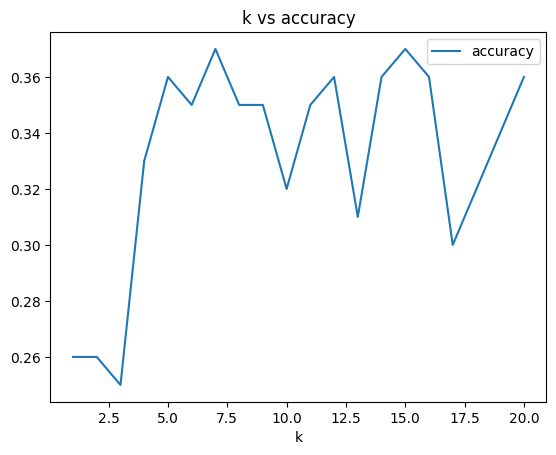

In [24]:
corona_sentiment_grid.plot(x='k', y='accuracy', kind='line', title='k vs accuracy')

Try this method on a dataset from the paper
https://www.kaggle.com/datasets/amananandrai/ag-news-classification-dataset

In [32]:
training_set_src = pd.read_csv(
    './AGNews_train.csv',
    encoding='iso-8859-1'
)
test_set_src = pd.read_csv(
    './AGNews_test.csv',
    encoding='iso-8859-1'
)
training_set_src.columns = ['label', 'title', 'description']
test_set_src.columns = ['label', 'title', 'description']

In [33]:
training_set_src['text'] = training_set_src['title'] + ' ' + training_set_src['description']
test_set_src['text'] = test_set_src['title'] + ' ' + test_set_src['description']

training_set = training_set_src[['text', 'label']].to_numpy()
test_set_sample = test_set_src.sample(sample_cnt)
test_set = test_set_sample[['text', 'label']].to_numpy()

In [39]:
agnews_grid = find_k_grid(range(5, 6), label='label')
agnews_grid

100%|██████████| 1/1 [09:14<00:00, 554.96s/it]


,k,accuracy
0,5,0.91
